# Replicating Calvano et al. (2020)
## Baseline - Stat des - Price cycles
### Author: Andréa Epivent

In [1]:
# Set working directory
import os
path = os.getcwd()

# Import packages
exec(open(path+"/packages.py").read())

# Import custom functions
from functions import *

# Import parameters
exec(open(path+"/parameters.py").read())

In [2]:
# Import data from training
q_table_1 = np.load(path+'/Output/Baseline/q_table_a1.npy')
q_table_2 = np.load(path+'/Output/Baseline/q_table_a2.npy')
A = np.load(path+'/Output/Baseline/actions.npy')
S = np.load(path+'/Output/Baseline/states.npy')
conv_info = np.load(path+'/Output/Baseline/conv_info.npy')
extra_profit = np.load(path+'/Output/Baseline/extra_profit.npy')
f_extra_profit = np.load(path+'/Output/Baseline/f_extra_profit.npy')
price1 = np.load(path+'/Output/Baseline/price1.npy')
price2 = np.load(path+'/Output/Baseline/price2.npy')

### Detect price cycles

* <b>Remark</b>: Stock next 40 price for both agents for each episode and keep last 20 prices. We do this because exploration can still occur towards end of episode, therefore it may take a few iterations for agents to converge to final strategies.

In [3]:
f_price1, f_price2 = get_forward_prices(40,q_table_1,q_table_2,conv_info,S,A)
f_price1 = f_price1[:,20:40]
f_price2 = f_price2[:,20:40]

* Check price cycle for both agents (Table 2)

In [4]:
cycles_a1 = price_cycle(f_price1)
cycles_a2 = price_cycle(f_price2)

In [5]:
# Agent 1
print(cycles_a1[cycles_a1==1].shape[0])
print(cycles_a1[cycles_a1==2].shape[0])
print(cycles_a1[cycles_a1>=3].shape[0])

2
2
1


In [6]:
# Agent 2
print(cycles_a2[cycles_a2==1].shape[0])
print(cycles_a2[cycles_a2==2].shape[0])
print(cycles_a2[cycles_a2>=3].shape[0])

2
2
1


In [7]:
# Max cycle length
print(max(cycles_a1))
print(max(cycles_a2))

4.0
4.0


### Check symmetry

* <b>Remark</b>: check symmetry in cycle length and in limit price (for cycle of length 1 only).

In [8]:
cycles = np.zeros((n_episodes,))
for j in range(n_episodes):
    if cycles_a1[j] == cycles_a2[j]:
        if cycles_a1[j] == 1:
            if f_price1[j][0] == f_price2[j][0]:
                cycles[j] = 1 # corresponds to "1-sym" case
            else:
                cycles[j] = 1.5 # corresponds to "1-asym" case
        else:
            cycles[j] = cycles_a1[j]
    else:
        cycles[j] = 99 # corresponds to "Hybrid" case

In [9]:
print(cycles[cycles==1].shape[0])
print(cycles[cycles==1.5].shape[0])
print(cycles[cycles==2].shape[0])
print(cycles[(cycles>=3)&(cycles<99)].shape[0])
print(cycles[cycles==99].shape[0])

1
1
2
1
0


In [11]:
# Save for later use
np.save(path+'/Output/Baseline/cycles', cycles)

### Graphs

* Visualize all price cycles (Figures 6, 10-13)

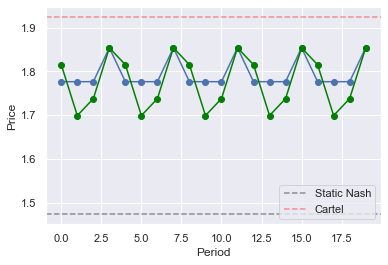

Cycle length: 4.0
Index: 0


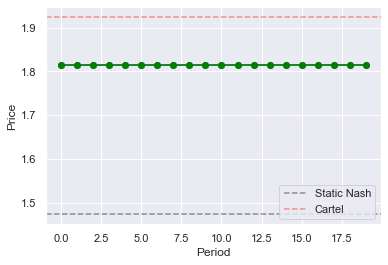

Cycle length: 1.0
Index: 1


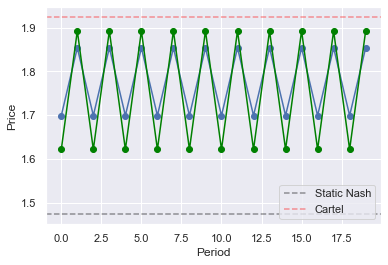

Cycle length: 2.0
Index: 2


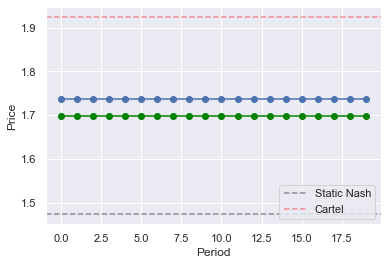

Cycle length: 1.5
Index: 3


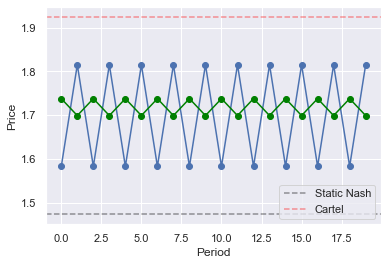

Cycle length: 2.0
Index: 4


In [12]:
for j in range(n_episodes):
    graph_cycle(f_price1[j],f_price2[j])
    print(f"Cycle length: {cycles[j]}")
    print(f"Index: {j}")

### Descriptive statistics per cycle length

* Processing

In [13]:
# Create cycle dataframe
df_cycle = pd.DataFrame(cycles,columns=["cycles"])

# Transform variable to string and deal with category
df_cycle.cycles = df_cycle.cycles.astype(int).astype(str)

# Create categories
df_cycle.cycles.replace("4","More",inplace=True)
df_cycle.cycles.replace("6","More",inplace=True)
df_cycle.cycles.replace("8","More",inplace=True)
df_cycle.cycles.replace("99","Hybrid",inplace=True)

df_cycle.cycles = pd.Categorical(df_cycle.cycles,
                                   categories=['1', '2', '3', 'More','Hybrid'],
                                   ordered=True)

In [14]:
# Concatenate with profits
df_extra_profit = pd.DataFrame(extra_profit,columns=["(Last) Extra profit"])
df_extra_profit["Forward mean extra profit"] = f_extra_profit

df_profitcycle = pd.concat([df_extra_profit,df_cycle],axis=1)

In [15]:
# Concatenate with prices
df_p1 = pd.DataFrame(price1,columns=["Final price"])
df_p1["Forward mean price"] = f_price1.mean(axis=1)
df_p1["agent"] = 1

df_p2 = pd.DataFrame(price2,columns=["Final price"])
df_p2["Forward mean price"] = f_price2.mean(axis=1)
df_p2["agent"] = 2

df_prices = pd.concat([df_p1,df_p2]).reset_index()

df_pricescycle = pd.concat([df_prices,pd.concat([df_cycle,df_cycle]).reset_index()],axis=1)

* Extra-profit

Figure 15 (based on final price)

Text(0, 0.5, '(Last) Extra profit')

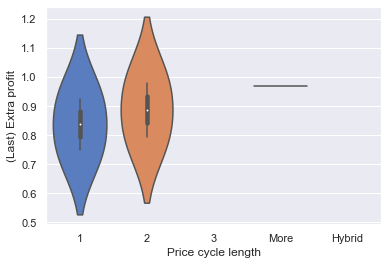

In [16]:
ax = sns.violinplot(x="cycles",y="(Last) Extra profit", data=df_profitcycle, palette="muted")
plt.xlabel('Price cycle length')
plt.ylabel('(Last) Extra profit')

Based on forward extra profit

Text(0, 0.5, 'Forward mean extra profit')

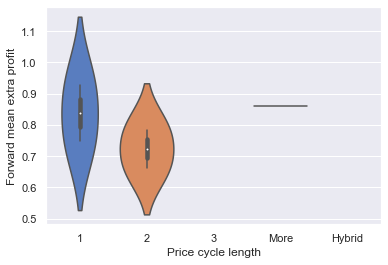

In [17]:
ax = sns.violinplot(x="cycles",y="Forward mean extra profit", data=df_profitcycle, palette="muted")
plt.xlabel('Price cycle length')
plt.ylabel('Forward mean extra profit')

Table 3

In [18]:
df_profitcycle

,(Last) Extra profit,Forward mean extra profit,cycles
0,0.968598,0.860911,More
1,0.926250,0.926250,1
2,0.980271,0.784111,2
3,0.747485,0.747485,1
4,0.795369,0.662955,2


In [19]:
print(df_profitcycle.groupby("cycles").mean())
print(df_profitcycle.groupby("cycles").std())
print(df_profitcycle["(Last) Extra profit"].mean())
print(df_profitcycle["(Last) Extra profit"].std())
print(df_profitcycle["Forward mean extra profit"].mean())
print(df_profitcycle["Forward mean extra profit"].std())

        (Last) Extra profit  Forward mean extra profit
cycles                                                
1                  0.836867                   0.836867
2                  0.887820                   0.723533
3                       NaN                        NaN
More               0.968598                   0.860911
Hybrid                  NaN                        NaN
        (Last) Extra profit  Forward mean extra profit
cycles                                                
1                  0.126406                   0.126406
2                  0.130745                   0.085670
3                       NaN                        NaN
More                    NaN                        NaN
Hybrid                  NaN                        NaN
0.8835944988286959
0.10571317083907705
0.7963423809479755
0.10170301202456722


* Prices (Figure 14)

Text(0, 0.5, 'Price')

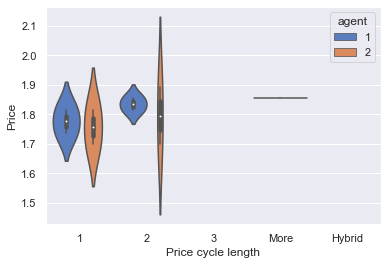

In [20]:
ax = sns.violinplot(x="cycles",y="Final price",hue="agent", data=df_pricescycle, palette="muted")
plt.xlabel('Price cycle length')
plt.ylabel('Price')

In [21]:
print(df_pricescycle.groupby("cycles").mean())
print(df_pricescycle.groupby("cycles").std())

        index  Final price  Forward mean price  agent  index
cycles                                                      
1         2.0     1.766762            1.766762    1.5    2.0
2         3.0     1.815196            1.737701    1.5    3.0
3         NaN          NaN                 NaN    NaN    NaN
More      0.0     1.853944            1.786136    1.5    0.0
Hybrid    NaN          NaN                 NaN    NaN    NaN
           index  Final price  Forward mean price     agent     index
cycles                                                               
1       1.154701     0.058121            0.058121  0.577350  1.154701
2       1.154701     0.083704            0.035371  0.577350  1.154701
3            NaN          NaN                 NaN       NaN       NaN
More    0.000000     0.000000            0.013699  0.707107  0.000000
Hybrid       NaN          NaN                 NaN       NaN       NaN
